# Training on 25,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Tue Aug 29 13:50:55 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   31C    P8     9W / 180W |    434MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   32C    P8     9W / 180W |   5637MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


### Load in the data.

In [23]:
%%time
modelpath   = "data/models/UNIF-10N-25T-1000E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-25000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T/3600E-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del train_frame
    del test_frame # To save on memory space.

Train is list of 25000 events.
Test is list of 3600 events.
CPU times: user 11.9 s, sys: 296 ms, total: 12.2 s
Wall time: 12.2 s


In [4]:
order = ["phi", "r", "z"]

### Show an example of the data.

Train 8881
Number of Hits: 87
Number of Tracks: 9


<IPython.core.display.Javascript object>


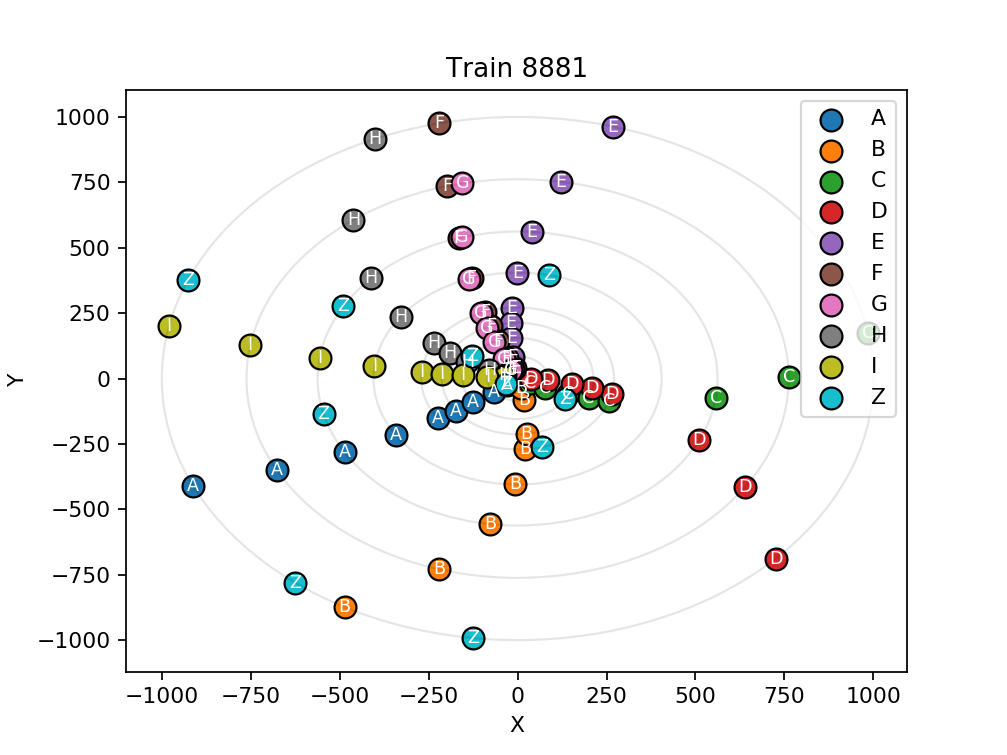

In [27]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [28]:
print(n)
visuals.display(train[n], order)

8881


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.895529,562.0,-80.662152,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.719777,1000.0,-48.289718,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.663688,762.0,-36.796765,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.615846,562.0,-27.138822,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.577248,405.0,-19.557336,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.546779,39.0,117.754959,,,,,,,,,,,,,,,,,,,,,,,,,,1,
6,-2.543667,271.0,-13.086514,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.527406,213.0,-10.285710,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.509782,155.0,-7.484906,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.485555,85.0,-4.104626,1,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [8]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [12]:
# If you have already created a model, run this cell to load the model.
# Else, just run the cell below this cell.
model = keras.models.load_model(modelpath)

In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [9]:
%%time
# Current model has been trained on 68 epochs before early stopping.
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=5, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)]))

Epoch 1/128
250/250 [==============================] - 367s - loss: 0.3860 - acc: 0.8800 - val_loss: 0.1899 - val_acc: 0.9457
Epoch 2/128
250/250 [==============================] - 354s - loss: 0.3859 - acc: 0.8801 - val_loss: 0.1908 - val_acc: 0.9454
Epoch 3/128
250/250 [==============================] - 355s - loss: 0.3827 - acc: 0.8813 - val_loss: 0.1892 - val_acc: 0.9459
Epoch 4/128
250/250 [==============================] - 354s - loss: 0.3823 - acc: 0.8812 - val_loss: 0.1915 - val_acc: 0.9453
Epoch 5/128
250/250 [==============================] - 355s - loss: 0.3862 - acc: 0.8798 - val_loss: 0.1900 - val_acc: 0.9457
Epoch 6/128
250/250 [==============================] - 355s - loss: 0.3834 - acc: 0.8810 - val_loss: 0.1890 - val_acc: 0.9461
Epoch 7/128
250/250 [==============================] - 355s - loss: 0.3833 - acc: 0.8809 - val_loss: 0.1902 - val_acc: 0.9458
Epoch 8/128
250/250 [==============================] - 356s - loss: 0.3820 - acc: 0.8813 - val_loss: 0.1873 - val_acc:

### Display information about the model after fitting it.

In [24]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 86.3214117745738%
Percent of tracks assigned correctly: 63.625745842325756%
Percent of events with the correct number of tracks: 83.05555555555556%
CPU times: user 1min 22s, sys: 60 ms, total: 1min 22s
Wall time: 1min 22s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 94.8051948051948%
Percent of tracks assigned correctly: 77.77777777777779%


<IPython.core.display.Javascript object>


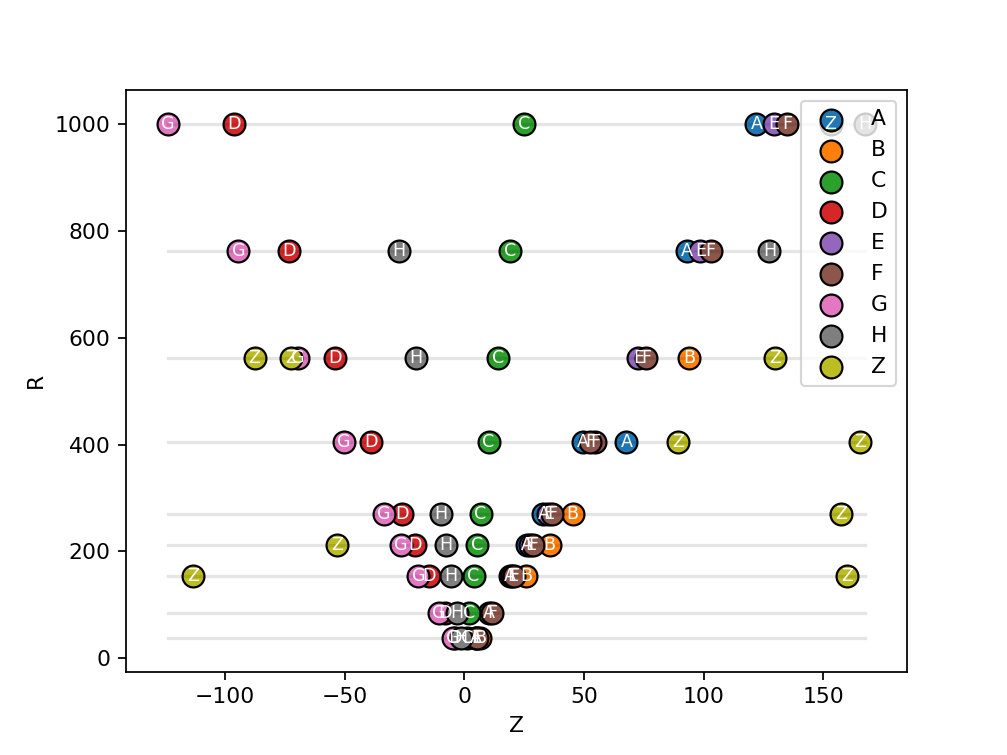

<IPython.core.display.Javascript object>


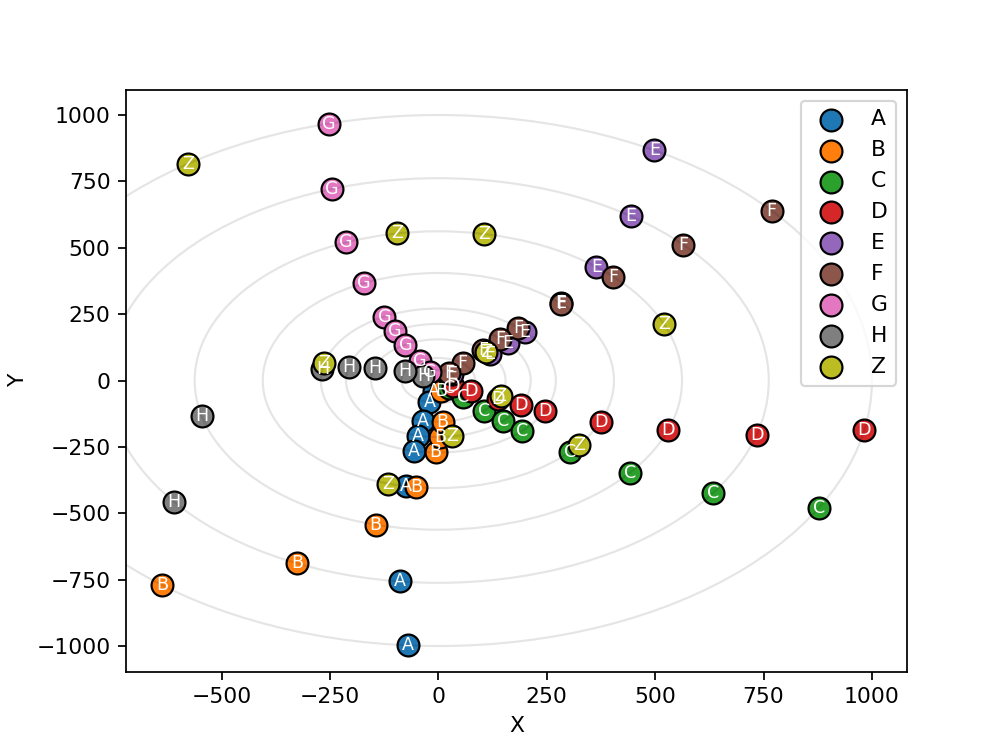

In [25]:
n = 10
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr")
_ = visuals.Plot2D(test[n], order).plot(mode="xy")

In [ ]:
d = visuals.Plot3D(test[n], order, guesses[n]).plot(title="Best Guess")
d = visuals.Plot3D(test[n], order).plot(title="Answer")

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

### Display the graphs.

<IPython.core.display.Javascript object>


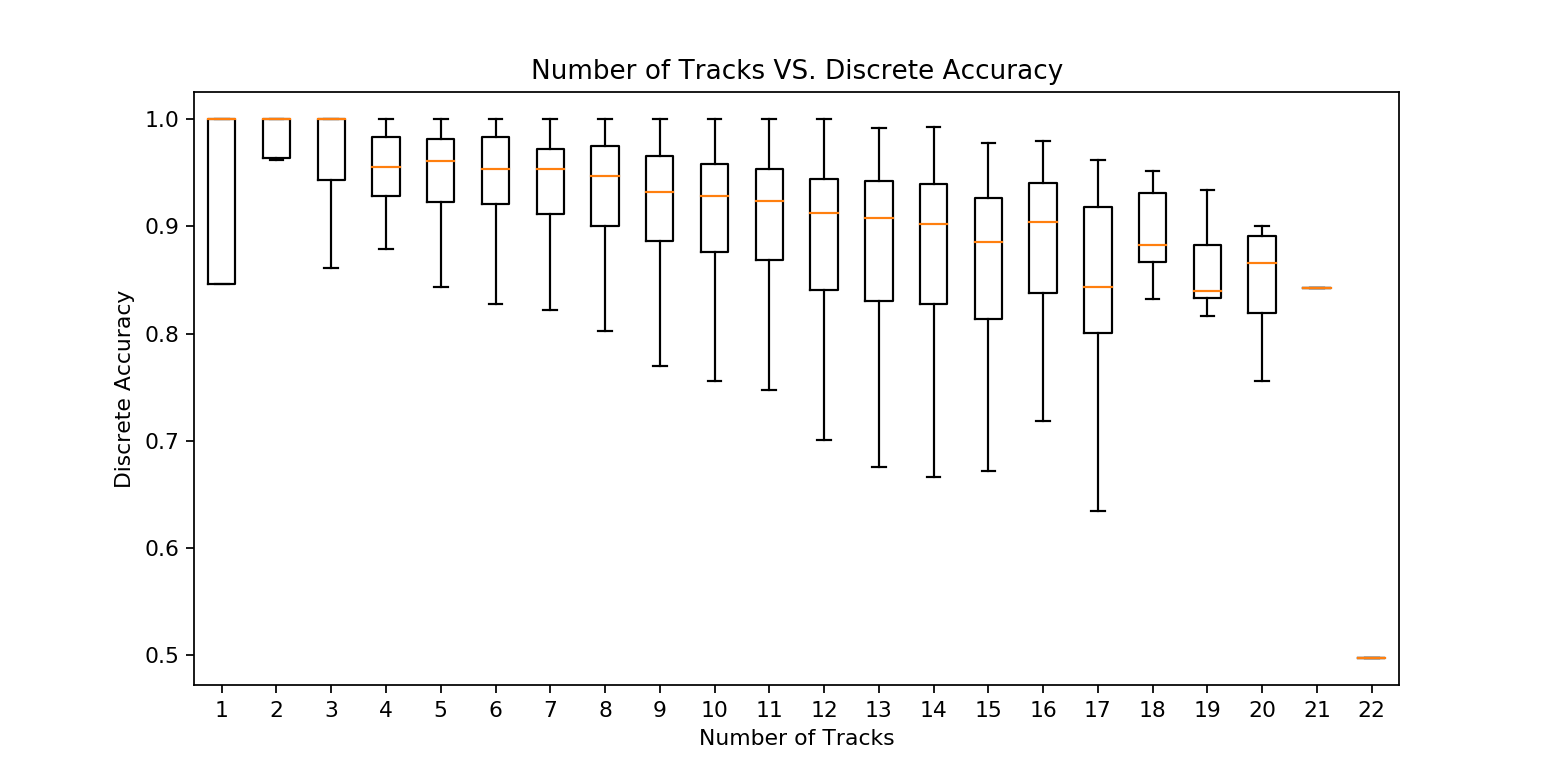

CPU times: user 28.9 s, sys: 20 ms, total: 28.9 s
Wall time: 28.9 s


In [26]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "Number of Tracks VS. Discrete Accuracy", "Number of Tracks", "Discrete Accuracy", xticks=list(r))